## Importing the Libraries and Initializing the Data

In [1]:
# Magic function to make the plots appear in-line
%matplotlib inline
# Arguments to stop display of the warnings
import warnings
warnings.filterwarnings('ignore')

# Importing the Required Packages
import numpy
import pandas
import seaborn
import matplotlib.pyplot as pyplot
import statsmodels.api as smApi

from collections import Counter

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

# Reading the CSV File as Pandas Data Frame
dataFrame = pandas.read_csv(r'Absenteeism_at_work.csv')
dataFrameCopy = dataFrame.copy()

## Data Validation and Review

In [2]:
# Printing Dataset Dimensions
print('Dataset Dimensions: {}'.format(dataFrame.shape))
print(dataFrame.info())
print('___________________________________________________________________')

# Checking for null data points
nullValueCount = dataFrame.isnull().sum()
nullFlag = False
for value in nullValueCount:
    if(int(value) > 0):
        nullFlag = True
        break
if (nullFlag == False):
    print('\n' + 'No Missing Values in the Data')
else:
    print(nullValueCount)

print('___________________________________________________________________')


# Printing Sample Data 
print('\n\n' + 'Sample Data from Dataset:')
dataFrame.head()

Dataset Dimensions: (740, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


## Pre-processing of Data

In [3]:
# Removal of Data Columns that will not have impact on prediction
dataFrame.drop(columns='ID', axis=1, inplace=True)

# Fixing Data Types for some of the columns to match the specifications
dataFrame['Day of the week'] = dataFrame['Day of the week'].astype('category')
dataFrame['Reason for absence'] = dataFrame['Reason for absence'].astype('category')
dataFrame['Seasons'] = dataFrame['Seasons'].astype('category')
dataFrame['Month of absence'] = dataFrame['Month of absence'].astype('category')
dataFrame['Social drinker'] = dataFrame['Social drinker'].astype('bool')
dataFrame['Education'] = dataFrame['Education'].astype('category')
dataFrame['Disciplinary failure'] = dataFrame['Disciplinary failure'].astype('bool')
dataFrame['Social smoker'] = dataFrame['Social smoker'].astype('bool')

# Reviewing the data
print(dataFrame.info())
print('___________________________________________________________________\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Reason for absence               740 non-null    category
 1   Month of absence                 740 non-null    category
 2   Day of the week                  740 non-null    category
 3   Seasons                          740 non-null    category
 4   Transportation expense           740 non-null    int64   
 5   Distance from Residence to Work  740 non-null    int64   
 6   Service time                     740 non-null    int64   
 7   Age                              740 non-null    int64   
 8   Work load Average/day            740 non-null    float64 
 9   Hit target                       740 non-null    int64   
 10  Disciplinary failure             740 non-null    bool    
 11  Education                        740 non-null    category
 12  Son     

## Exploratory Data Analysis

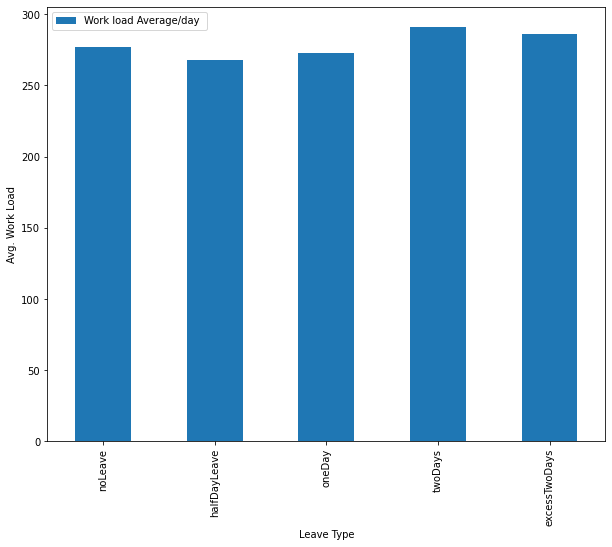

In [4]:
# Comparing avg. work load vs leave type
bins = [-numpy.inf,0,4, 8, 16, numpy.inf]
binLabelArr = ['noLeave','halfDayLeave', 'oneDay', 'twoDays', 'excessTwoDays']
dataFrameCopy['New Absenteeism Class'] = pandas.cut(dataFrameCopy['Absenteeism time in hours'], bins, labels=binLabelArr)
ageWorkSum = dataFrameCopy.groupby('New Absenteeism Class', as_index=False)[['Work load Average/day ']].mean()
ax = ageWorkSum.plot(kind='bar', x='New Absenteeism Class', figsize=(10,8))
ax.set_ylabel('Avg. Work Load')
ax.set_xlabel('Leave Type')
pyplot.show()

#### There seems to be no significant impact of avg. work load on leave type

halfDayLeave     417
oneDay           216
noLeave           44
excessTwoDays     44
twoDays           19
Name: New Absenteeism Class, dtype: int64


<AxesSubplot:xlabel='New Absenteeism Class', ylabel='count'>

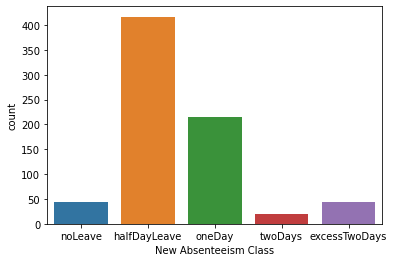

In [5]:
# Checking count based on Class assigned
print(dataFrameCopy['New Absenteeism Class'].value_counts())
seaborn.countplot(dataFrameCopy['New Absenteeism Class'])

#### Employees/ Delivery Boys seem to have taken the most number of leaves as half day leaves followed by one day leaves

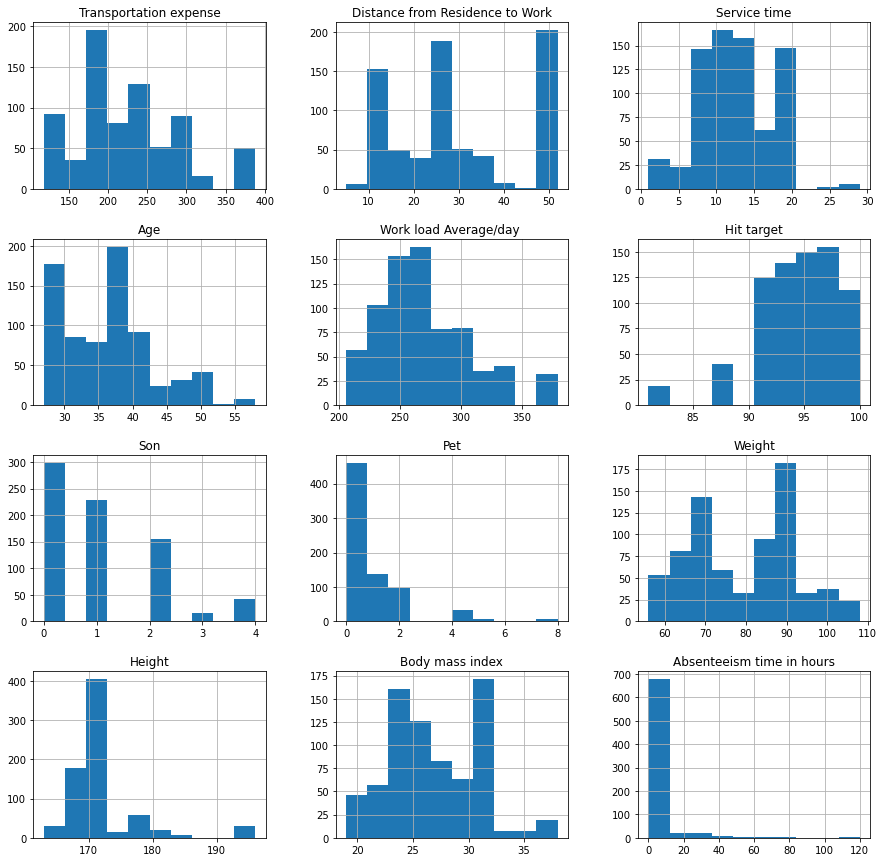

In [6]:
# Viewing distribution/ histogram of the datapoints available
dataFrame.hist(figsize=(15, 15));

In [7]:
# Comparing Reasons for Absenteeism

reasonMap = {
    0: 'Unknown',
    1: 'Certain infectious and parasitic diseases',
    2: 'Neoplasms',
    3: 'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
    4: 'Endocrine, nutritional and metabolic diseases',
    5: 'Mental and behavioural disorders',
    6: 'Diseases of the nervous system',
    7: 'Diseases of the eye and adnexa',
    8: 'Diseases of the ear and mastoid process',
    9: 'Diseases of the circulatory system',
    10: 'Diseases of the respiratory system',
    11: 'Diseases of the digestive system',
    12: 'Diseases of the skin and subcutaneous tissue',
    13: 'Diseases of the musculoskeletal system and connective tissue',
    14: 'Diseases of the genitourinary system',
    15: 'Pregnancy, childbirth and the puerperium',
    16: 'Certain conditions originating in the perinatal period',
    17: 'Congenital malformations, deformations and chromosomal abnormalities',
    18: 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified',
    19: 'Injury, poisoning and certain other consequences of external causes',
    20: 'External causes of morbidity and mortality',
    21: 'Factors influencing health status and contact with health services',
    22: 'Patient follow-up',
    23: 'Medical consultation',
    24: 'Blood donation',
    25: 'Laboratory examination',
    26: 'Unjustified absence',
    27: 'Physiotherapy',
    28: 'Dental consultation'
}
dataFrameCopy['reasonLabels'] = dataFrameCopy['Reason for absence'].map(reasonMap)
reasonLabels = dataFrameCopy.groupby('reasonLabels', as_index=False)['Absenteeism time in hours'].sum()
with pandas.option_context('display.max_colwidth', -1):
    display(reasonLabels.sort_values('Absenteeism time in hours', ascending=True))


,reasonLabels,Absenteeism time in hours
27,Unknown,0
1,Certain conditions originating in the perinatal period,6
3,"Congenital malformations, deformations and chromosomal abnormalities",8
5,Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism,8
15,"Endocrine, nutritional and metabolic diseases",9
24,"Pregnancy, childbirth and the puerperium",16
20,Mental and behavioural disorders,19
21,Neoplasms,24
0,Blood donation,24
8,Diseases of the ear and mastoid process,32


#### Muscle/ Skeletal related issues seem to be the leading cause of absences followed by Injury and issues due to external circumstances

<AxesSubplot:>

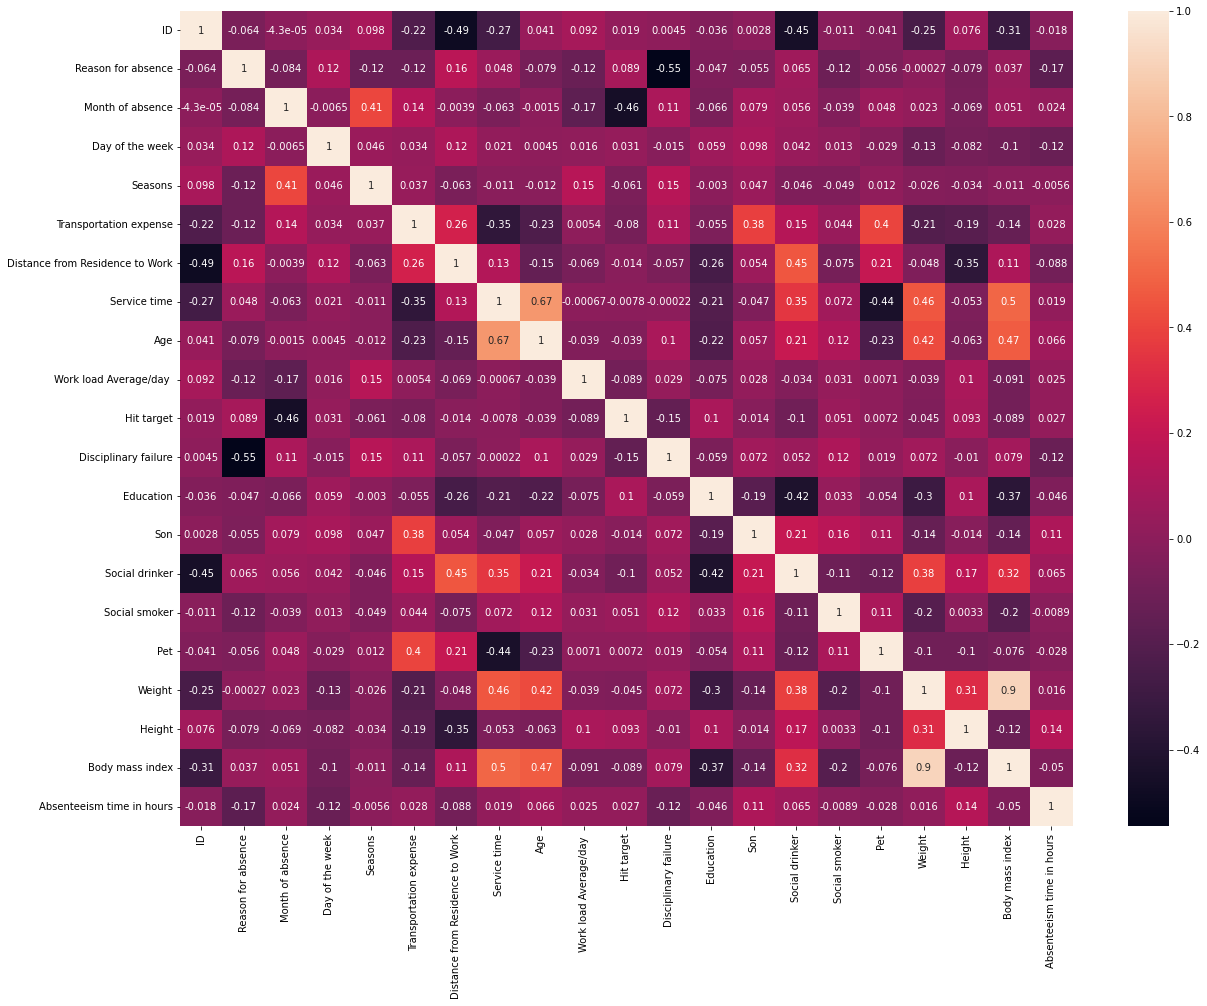

In [15]:
# Finding Correlation Between the input data points
pyplot.figure(figsize=(20, 15))
seaborn.heatmap(dataFrameCopy.corr(), annot=True)

#### We may have to eliminate 'Age' or 'Service time' for final model building process as they have high correlation as per heatmap. Weight and body mass index are also highly correlated.

## Building The Model

### Random Forest Regression Model

In [9]:
# Splitting Training Data and Test Data
x = dataFrame.drop(columns='Absenteeism time in hours',axis=1)
y = dataFrame['Absenteeism time in hours']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.4, random_state=33)

model = RandomForestRegressor(n_estimators=666, random_state=33, oob_score=True)
model.fit(xTrain,yTrain)
yPred = model.predict(xTest)

# Checking metrics for the model
testScore = r2_score(yTest, yPred)
rmseTest = mean_squared_error(yTest, yPred) ** (1/2)

print(f'Out-of-bag score : {model.oob_score_:>5.3}'+'\n')
print(f'Test data R-2 score: {testScore:>5.3}'+'\n')
print(f'Test set of RMSE : {rmseTest:.2f}'+'\n')

Out-of-bag score : -0.24

Test data R-2 score: 0.132

Test set of RMSE : 14.22



The results from the Random Forest Regression Model indicate that this is not a suitable model for the prediction.

#### Adopting approach of updating the 'Absenteeism in hours' as categorical variable:
##### Proposed Categories for X hours absence:
##### X == 0 Hours Absence : noLeave
##### X <=4 Hours Absence : halfDayLeave
##### 4 < X <=8 Hours Absence : oneDay
##### 8 < X <= 16 Hours Absence : twoDays
##### 16 > X Hours Absence : excessTwoDays

In [10]:
bins = [-numpy.inf,0,4, 8, 16, numpy.inf]
binLabelArr = ['noLeave','halfDayLeave', 'oneDay', 'twoDays', 'excessTwoDays']
dataFrame['New Absenteeism Class'] = pandas.cut(dataFrame['Absenteeism time in hours'], bins, labels=binLabelArr)
dataFrame.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,New Absenteeism Class
0,26,7,3,1,289,36,13,33,239.554,97,...,1,2,True,False,1,90,172,30,4,halfDayLeave
1,0,7,3,1,118,13,18,50,239.554,97,...,1,1,True,False,0,98,178,31,0,noLeave
2,23,7,4,1,179,51,18,38,239.554,97,...,1,0,True,False,0,89,170,31,2,halfDayLeave
3,7,7,5,1,279,5,14,39,239.554,97,...,1,2,True,True,0,68,168,24,4,halfDayLeave
4,23,7,5,1,289,36,13,33,239.554,97,...,1,2,True,False,1,90,172,30,2,halfDayLeave


### Random Forest Classifier Model

In [11]:
x = dataFrame.drop(columns=['New Absenteeism Class','Absenteeism time in hours'],axis=1)
y = dataFrame['New Absenteeism Class']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.4, random_state=33)
model = RandomForestClassifier(n_estimators=200, random_state=0, oob_score=True, n_jobs=-1)
model.fit(xTrain,yTrain)
yPred = model.predict(xTest)

# Checking metrics for the model
print("Accuracy:")
print(metrics.accuracy_score(yTest, yPred))
print("Classification Report:")
print(classification_report(yTest, yPred))
print("Confusion Matrix:")
print(confusion_matrix(yTest, yPred))

Accuracy:
0.722972972972973
Classification Report:
               precision    recall  f1-score   support

excessTwoDays       0.60      0.12      0.19        26
 halfDayLeave       0.82      0.85      0.84       170
      noLeave       1.00      1.00      1.00        15
       oneDay       0.52      0.66      0.58        77
      twoDays       0.00      0.00      0.00         8

     accuracy                           0.72       296
    macro avg       0.59      0.53      0.52       296
 weighted avg       0.71      0.72      0.70       296

Confusion Matrix:
[[  3   2   0  21   0]
 [  1 145   0  23   1]
 [  0   0  15   0   0]
 [  1  25   0  51   0]
 [  0   4   0   4   0]]


#### Model Accuracy: 72%
#### Much more accurate compared to the Regression Model

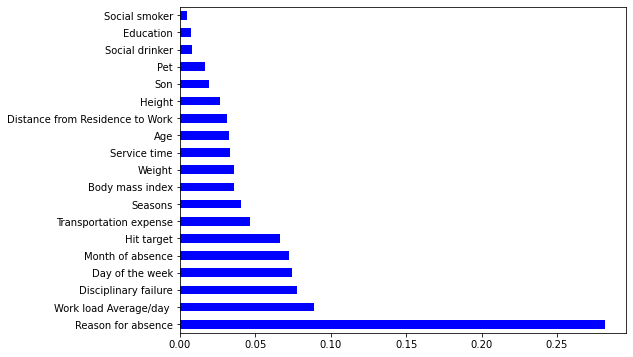

In [12]:
# Checking feature priority
ax = (pandas.Series(model.feature_importances_, index=x.columns)
      .nlargest(20)
      .plot(kind='barh', figsize=(8,6), color='blue'))
pyplot.show()

Removing 'Social smoker','Education','Social drinker','Pet','Son','Body mass index' as low feature importance
Removing 'Age' as high correlation with 'Service time'

### Random Forest Classifier Model (Updated)

In [13]:
x = dataFrame.drop(columns=['New Absenteeism Class','Absenteeism time in hours','Social smoker','Education','Social drinker','Pet','Son','Body mass index','Age'],axis=1)
y = dataFrame['New Absenteeism Class']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.4, random_state=33)
model = RandomForestClassifier(n_estimators=200, random_state=0, oob_score=True, n_jobs=-1)
model.fit(xTrain,yTrain)
yPred = model.predict(xTest)

# Checking metrics for the model
print("Accuracy:")
print(metrics.accuracy_score(yTest, yPred))
print("Classification Report:")
print(classification_report(yTest, yPred))
print("Confusion Matrix:")
print(confusion_matrix(yTest, yPred))

Accuracy:
0.722972972972973
Classification Report:
               precision    recall  f1-score   support

excessTwoDays       0.50      0.08      0.13        26
 halfDayLeave       0.83      0.85      0.84       170
      noLeave       1.00      1.00      1.00        15
       oneDay       0.53      0.68      0.59        77
      twoDays       0.00      0.00      0.00         8

     accuracy                           0.72       296
    macro avg       0.57      0.52      0.51       296
 weighted avg       0.71      0.72      0.70       296

Confusion Matrix:
[[  2   2   0  20   2]
 [  1 145   0  23   1]
 [  0   0  15   0   0]
 [  1  24   0  52   0]
 [  0   4   0   4   0]]


#### The Model Accuracy has improved very slightly with removal of the low importance features
#### Final Model Accuracy: 72% 